In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install --quiet torchviz
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
import time
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import seaborn as sn
from copy import deepcopy, copy
import math
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install --quiet torchviz
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def training_step(model,f_loss,opt):
  #So we can stick this in the loop and it does things
  def actually_train(x,y):

    model.train() #Gotta set it for reasons unknown

    #Step 1: Make yhat
    yhat = model(x)

    #Step 2: Get loss
    Loss = f_loss(yhat,y)

    #Step 3: Grad:
    Loss.backward()

    #Step 4: Optimizer Update
    optimizer.step()
    optimizer.zero_grad()#always do this

    #Give back loss:
    return Loss
  #Now call the lil function
  return actually_train

# First We Import The Data

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


In [5]:
import zipfile
import os

Train_Images = zipfile.ZipFile('/content/gdrive/MyDrive/Colab Notebooks/COS/Assignment 3/Actual_Work/Train_Images.zip', 'r') #Opens the zip file in read mode
Train_Images.extractall('/tmp') #Extracts the files into the /tmp folder
Train_Images.close()

In [12]:
df = pd.read_csv("Train.csv")
df.head

<bound method NDFrame.head of          Image_ID            class   xmin   ymin  width  height
0     ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0
1     ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5
2     ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5
3     ID_00ZJEEK3    fruit_healthy  125.0  193.0  254.5   217.0
4     ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0
...           ...              ...    ...    ...    ...     ...
3901  ID_ZZAB1FH1    fruit_healthy   96.0  175.5  289.5   222.0
3902  ID_ZZAB1FH1    fruit_healthy  330.0  241.0  182.0   180.5
3903  ID_ZZJZ2CV6    fruit_healthy  358.0  234.0  134.5   107.0
3904  ID_ZZJZ2CV6    fruit_healthy   98.5  135.0  275.5   213.5
3905  ID_ZZO9KIH9  fruit_woodiness  123.5  218.5  197.5   153.5

[3906 rows x 6 columns]>

In [8]:
Normal_Square = 0
Weird = 0
for n in range(len(df)):
  id = df.iloc[n]["Image_ID"]
  img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
  Box_shape = np.shape(img)
  if Box_shape == (512,512,3):
    Normal_Square +=1
  else:
    Weird+=1
print("Square onEs:",Normal_Square)
print("Weird:",Weird)

Square onEs: 3906
Weird: 0


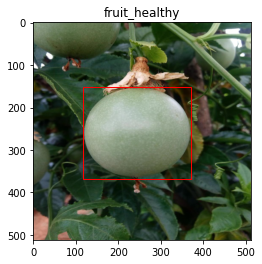

In [21]:
n = 679
bboxes =  df[["xmin","ymin","width","height"]]
bboxes = np.array(bboxes)
id = df.iloc[n]["Image_ID"]
Class = df.iloc[n]["class"]
img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
imgplot = plt.imshow(img)
bbox = bboxes[n]
plt.title(Class)
in_xs = [0,0,512,200]
def coords_to_bbox(coords):
  xmin = coords[0]
  ymin = coords[1]
  xmax = coords[2]
  ymax = coords[3]
  w = xmax-xmin
  h = ymax-ymin
  bbox = [xmin,ymin,w,h]
  return bbox
#bbox = coords_to_bbox(in_xs)
bbox = bbox
plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

## So Now We wanna Construct our Bounding Box List:

In [22]:
def bbox_to_scaled_coords(bbox):
  xmin = bbox[0]
  ymin = bbox[1]
  w = bbox[2]
  h = bbox[3]
  xmax = xmin+w
  ymax = ymin+h
  orig = [xmin, ymin, xmax, ymax]
  scaled_Box = [x / 512 for x in orig]
  return scaled_Box

In [23]:
bboxes

array([[ 87. ,  87.5, 228. , 311. ],
       [ 97.5,  17.5, 245. , 354.5],
       [156.5, 209.5, 248. , 302.5],
       ...,
       [358. , 234. , 134.5, 107. ],
       [ 98.5, 135. , 275.5, 213.5],
       [123.5, 218.5, 197.5, 153.5]])

In [24]:
Bound_Boxes = []
for bbox in bboxes:
  xmin = bbox[0]
  ymin = bbox[1]
  w = bbox[2]
  h = bbox[3]
  xmax = xmin+w
  ymax = ymin+h
  Bound_Boxes.append([xmin, ymin, xmax, ymax])

In [25]:
orig = Bound_Boxes[10]
print(orig)
newList = [x / 512 for x in orig]
print(newList)

[220.5, 84.0, 382.0, 311.0]
[0.4306640625, 0.1640625, 0.74609375, 0.607421875]


In [65]:
np.shape(img)

(512, 512, 3)

(512, 512, 3)

## Now We Construct our Dataset Object

In [84]:
def class_binarizer(CLASS):
  n = 0 
  for c in ['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy']:
    if CLASS  == c:
      clss = n
    else:
      n+=1
  return clss
def class_one_hot(CLASS):
  out = np.zeros(3)
  clss = class_binarizer(CLASS)
  out[clss]+=1
  return out

In [121]:
class Fruit_Dataset(Dataset):
  def __init__(self,df):
    #self.X = x
    self.Class = df["class"]
    self.BBOX = df[["xmin","ymin","width","height"]]
    self.Image_ID = df["Image_ID"]
    Bound_Boxes = []
    for bbox in bboxes:
      scaled_Box = bbox_to_scaled_coords(bbox)
      Bound_Boxes.append(scaled_Box)
    self.scaled_Bound_Boxes = Bound_Boxes
    Bound_Boxes = []
    for bbox in bboxes:
      xmin = bbox[0]
      ymin = bbox[1]
      w = bbox[2]
      h = bbox[3]
      xmax = xmin+w
      ymax = ymin+h
      Bound_Boxes.append([xmin, ymin, xmax, ymax])
    self.Unscaled_Bound_boxes = Bound_Boxes
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.Class)
  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        id = self.Image_ID[index]
        img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
        X = self.transform(img)
        index = 67
        clss = self.Class[index]
        yclass = class_one_hot(clss)
        Ybbox = self.scaled_Bound_Boxes[index]
        ybbox = np.array(Ybbox)
        Y = []
        Y = np.append(ybbox,yclass)

        return X,Y
  image_size = 300
  transform = T.Compose([
        T.ToPILImage(),
        T.Resize(image_size),
        T.ToTensor()])

In [107]:
data.scaled_Bound_Boxes[60]

[0.2607421875, 0.2490234375, 0.7138671875, 0.7734375]

In [102]:
ythingies

[0.4306640625,
 0.1640625,
 0.74609375,
 0.607421875,
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.])]

In [110]:
index = 67
clss = data.Class[index]
yclass = class_one_hot(clss)
Ybbox = data.scaled_Bound_Boxes[index]
ybbox = np.array(Ybbox)
Y = []
Y = np.append(ybbox,yclass)
print(Y)

[0.26171875 0.42871094 0.56738281 0.67382812 0.         0.
 1.        ]


In [116]:
data = Fruit_Dataset(df)

In [120]:
np.shape(x)

NameError: ignored

[0.26171875 0.42871094 0.56738281 0.67382812 0.         0.
 1.        ]


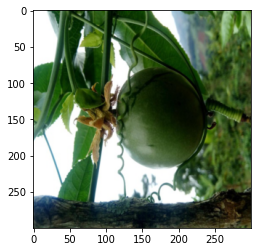

In [119]:
X,Y = data.__getitem__(3)
plt.imshow(X.T)
print(Y)

In [83]:
index = 4
clss = data.Class[index]
print(clss)
print(class_binarizer(clss))
print(class_one_hot(clss))

fruit_brownspot
1
[0. 1. 0.]


In [30]:
batch_size = 15
transformed_dataset = Fruit_Dataset(df)
train_dl = DataLoader(transformed_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [31]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [32]:
#for img in train_dl:


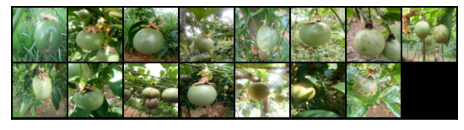

In [33]:
show_batch(train_dl)

# Contructing A Basic Classifying CNN

In [42]:
import pycocotools

In [43]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:

LR = 0.225
loss = nn.CrossEntropyLoss()
net = neural_network().to(device)

net = nn.Sequential(
    nn.Linear(6,10),
    nn.Tanh(), 
    nn.Linear(10,10),
    nn.Tanh(),
    nn.Linear(10,10),
    nn.Tanh(),
    nn.Linear(10,3),
  ).to(device)

optimizer = torch.optim.SGD(net.parameters(),lr = LR)

train_ds = StudentDataset(file_2, n_rows=3000) #THis loads the first 5 rows of the guy
test_ds = StudentDataset(file_1,n_rows = 3000)
train_ldr = torch.utils.data.DataLoader(train_ds,
  batch_size= 10, shuffle=True)

LOSS = []

training_step_funct = training_step(net,loss,optimizer)

Step_Epoch = []
Acc_Epoch = []
Accuracy = []
Test_ACC = []

total_epochs = 1000

for epoch in range(0, total_epochs):
  E = 0
  for (batch_idx, batch) in enumerate(train_ldr):
    X = batch['predictors']  # inputs
    Y = batch['targets']     # shape [10,3] (!)
    
    loss = training_step_funct(X, Y)
    E += loss

  LOSS.append(E.detach().numpy())# can also just use .item
  clear_output(wait=True)

  if epoch % 1 ==0:
    samps = torch.utils.data.RandomSampler(train_ds, replacement=True, num_samples=100, generator=None)
    samp_set = train_ds[list(samps)]

    Nc,Ni,acc = accuracy_quick_dict(net, samp_set)
    Accuracy.append(acc)

    test_samps = torch.utils.data.RandomSampler(test_ds, replacement=True, num_samples=100, generator=None)
    test_samp_set = test_ds[list(test_samps)]


    Nc,Ni,test_acc = accuracy_quick_dict(net, test_samp_set)
    Test_ACC.append(test_acc)

    Acc_Epoch.append(epoch)
  if epoch % 1 == 0:
    print("epoch = {}   loss = {} accuracy = {} test accuracy = {} ".format(epoch, E,acc,test_acc))

    Step_Epoch.append(epoch)

  # TODO: save checkpoint

plt.figure(figsize = [10,7])
plt.plot(range(total_epochs),LOSS)
plt.title("Loss Function")
plt.xlabel("Epoch")
plt.ylabel("Loss")

n_final_acc = int(len(Acc_Epoch)/8)
plt.figure(figsize = [10,7])
plt.plot(Acc_Epoch,Accuracy,Acc_Epoch,Test_ACC,np.linspace(Acc_Epoch[-n_final_acc],total_epochs,n_final_acc),np.ones(n_final_acc)*np.mean(Accuracy[-n_final_acc:]),"--",)

p = np.mean(Accuracy[-n_final_acc:])
n = 3
plt.title("Accuracy Per Epoch (Final Acc: {0:.{1}f}%)".format(p*100, n))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")